In [1]:
import pandas as pd
import numpy as np
import re

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from wordcloud import WordCloud

from code.viz import word_plot

sns.set()

from joblib import parallel_backend, Parallel, delayed
from multiprocessing import Pool
import multiprocessing

# increasing display to view large descriptions and reviewText
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
revtext_genre = pd.read_csv('./data/revtext_cont_based.csv')
revtext_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346445 entries, 0 to 2346444
Data columns (total 8 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   rating       int64 
 1   user_id      object
 2   movie_id     object
 3   reviews      object
 4   genre        object
 5   description  object
 6   title        object
 7   starring     object
dtypes: int64(1), object(7)
memory usage: 143.2+ MB


In [36]:
revtext_genre = revtext_genre[(revtext_genre['reviews'].str.len() >= 300) & (revtext_genre['reviews'].str.len() <= 1000)]
revtext_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361797 entries, 13 to 2346443
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   rating       361797 non-null  int64 
 1   user_id      361797 non-null  object
 2   movie_id     361797 non-null  object
 3   reviews      361797 non-null  object
 4   genre        361797 non-null  object
 5   description  361797 non-null  object
 6   title        361797 non-null  object
 7   starring     361797 non-null  object
dtypes: int64(1), object(7)
memory usage: 24.8+ MB


In [37]:
one_df = revtext_genre[revtext_genre['rating'] == 1]
two_df = revtext_genre[revtext_genre['rating'] == 2]
three_df = revtext_genre[revtext_genre['rating'] == 3]
four_df = revtext_genre[revtext_genre['rating'] == 4]
five_df = revtext_genre[revtext_genre['rating'] == 5]

In [90]:
content_based = five_df.copy()
content_based.drop(columns=['rating','user_id', 'description','title','starring'],axis=1,inplace=True)
content_based.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206041 entries, 35 to 2346443
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   movie_id  206041 non-null  object
 1   reviews   206041 non-null  object
 2   genre     206041 non-null  object
dtypes: object(3)
memory usage: 6.3+ MB


In [41]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags

    Provided by Flatiron School
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [42]:
sw = stopwords.words('english')

tokenizer = RegexpTokenizer('\w+')

lemmer = WordNetLemmatizer()

regex_template = r"[^\w\s]"

In [43]:
def preprocess_and_lemmatize(text):
    text = re.sub(regex_template, '', text)
    
    text = text.lower()

    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]

    lemmatized_words = [lemmer.lemmatize(word, pos=get_wordnet_pos(tag))
                        for word, tag in pos_tag(words)]
    
    return ' '.join(lemmatized_words)

In [44]:
def tokenize_sw(text):
    
    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]
    
    return ' '.join(words)

In [ ]:
content_based['reviews'] = content_based['reviews'].apply(preprocess_and_lemmatize)
content_based.head()

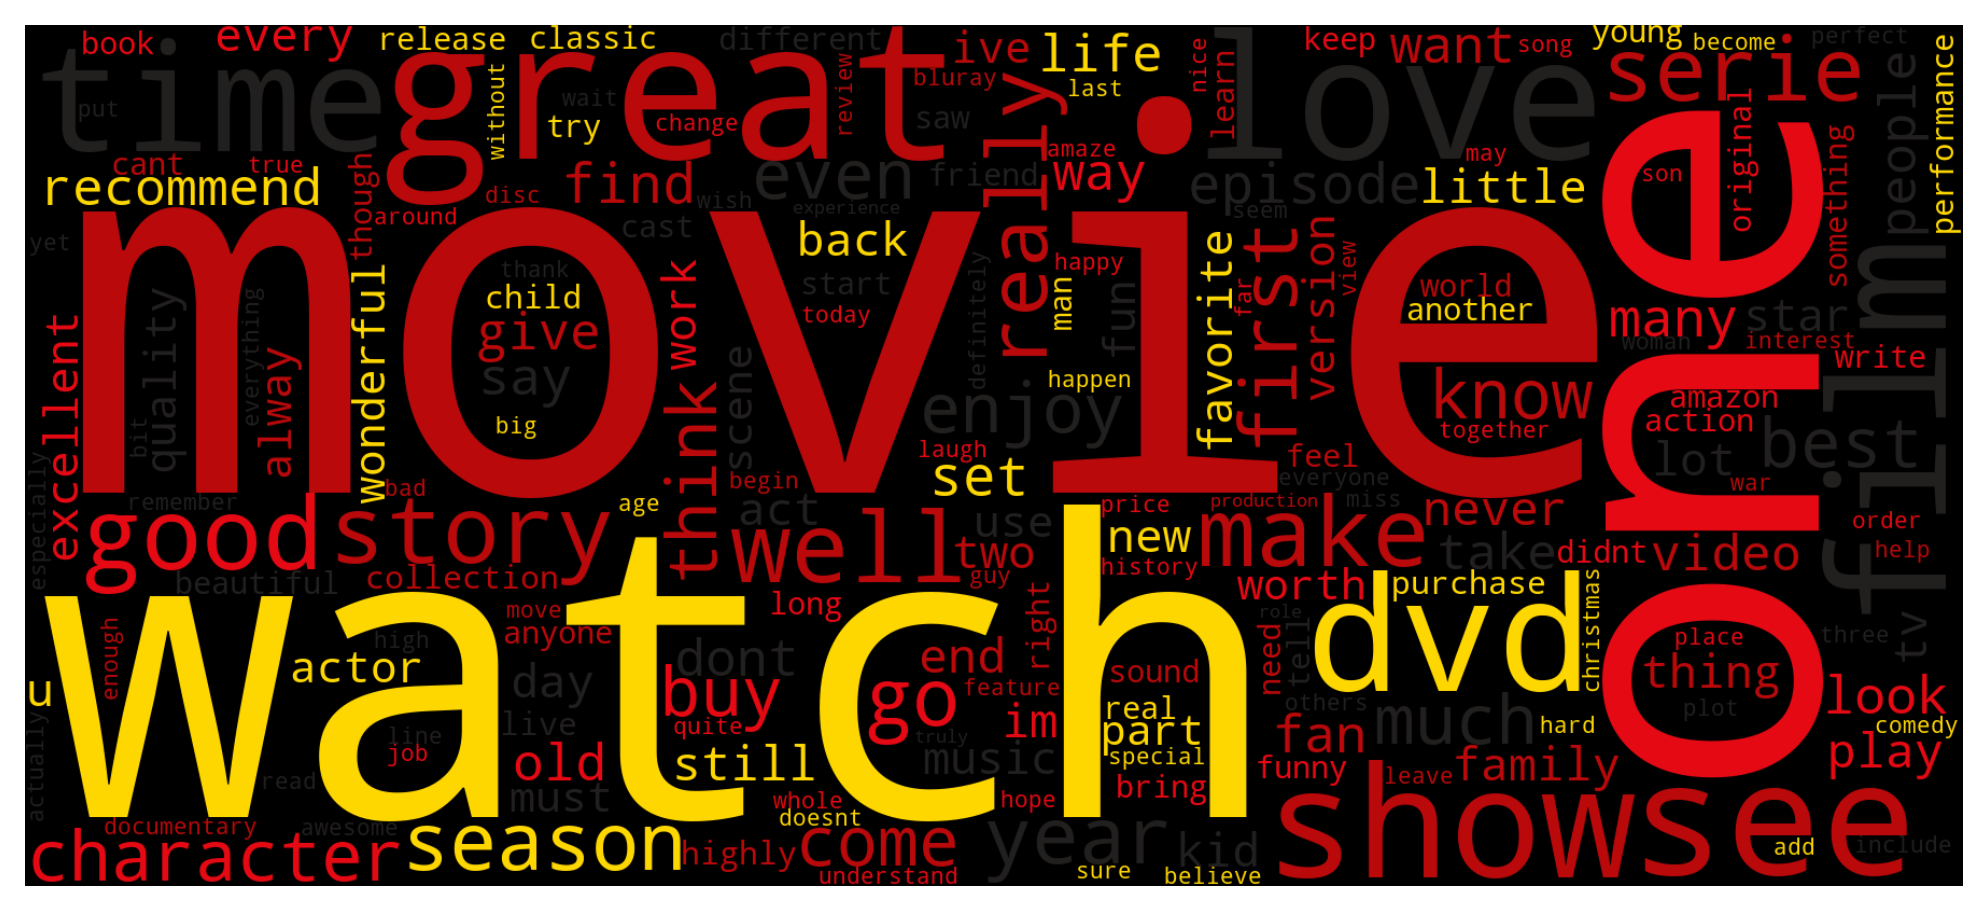

In [48]:
flix_colors = [
    "#221f1f", "#b9090b",
    "#e50914", "#ffd700"
]
canvamap = ListedColormap(flix_colors)


wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='black'
).generate(' '.join(content_based['reviews']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

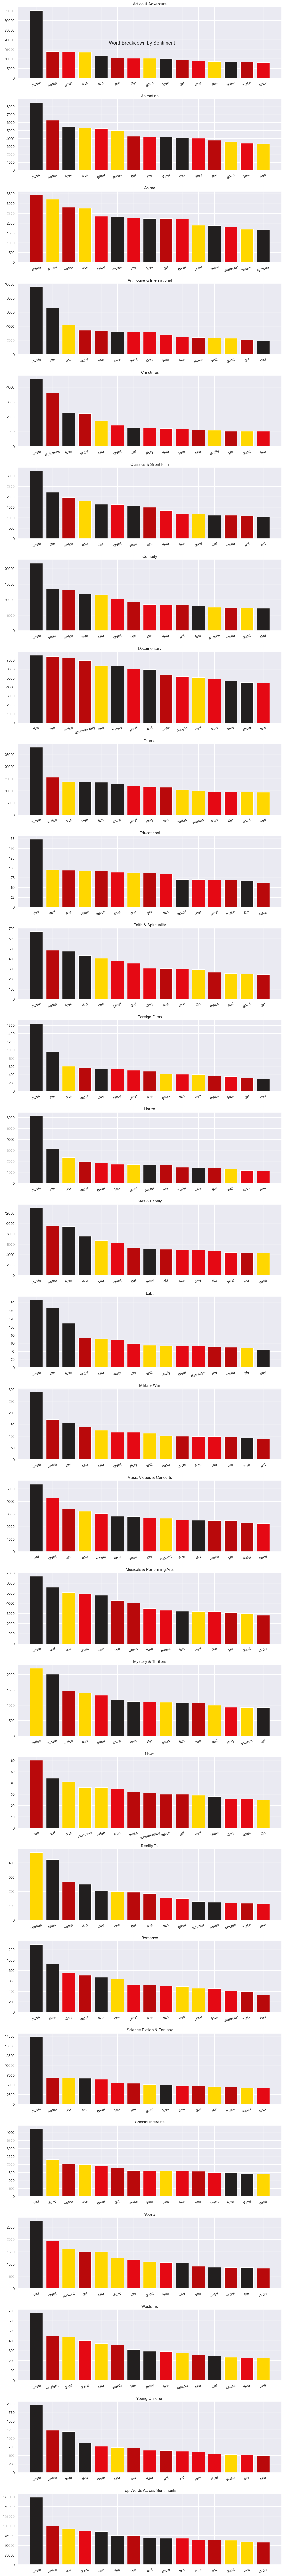

In [49]:
freq_words = word_plot(content_based, 'genre', 'reviews',
    n_words=15, theme=flix_colors)

In [50]:
specific_words = [
    'movie', 'watch', 'dvdr', 'dvd', 'vcr','dvr',
    'vhs', 'demand', 'use', 'film', 'video', 'young', 'feature'
    'one', 'great', 'love', 'show', 'like', 'good'
]

sw.extend(specific_words)

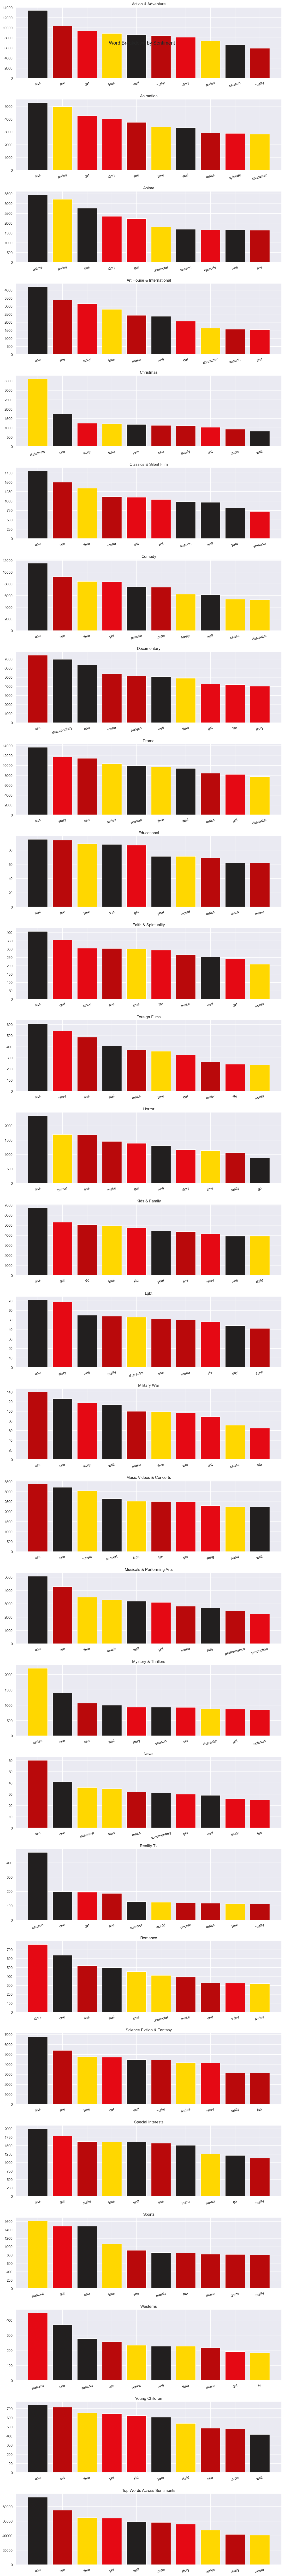

In [51]:
content_based['reviews'] = content_based['reviews'].apply(tokenize_sw)
freq_words = word_plot(content_based, 'genre', 'reviews',
    n_words=10, theme=flix_colors)

In [52]:
more_words = [
    'one', 'really', 'see', 'time', 'get', 'story', 'series', 'would'
]

sw.extend(more_words)

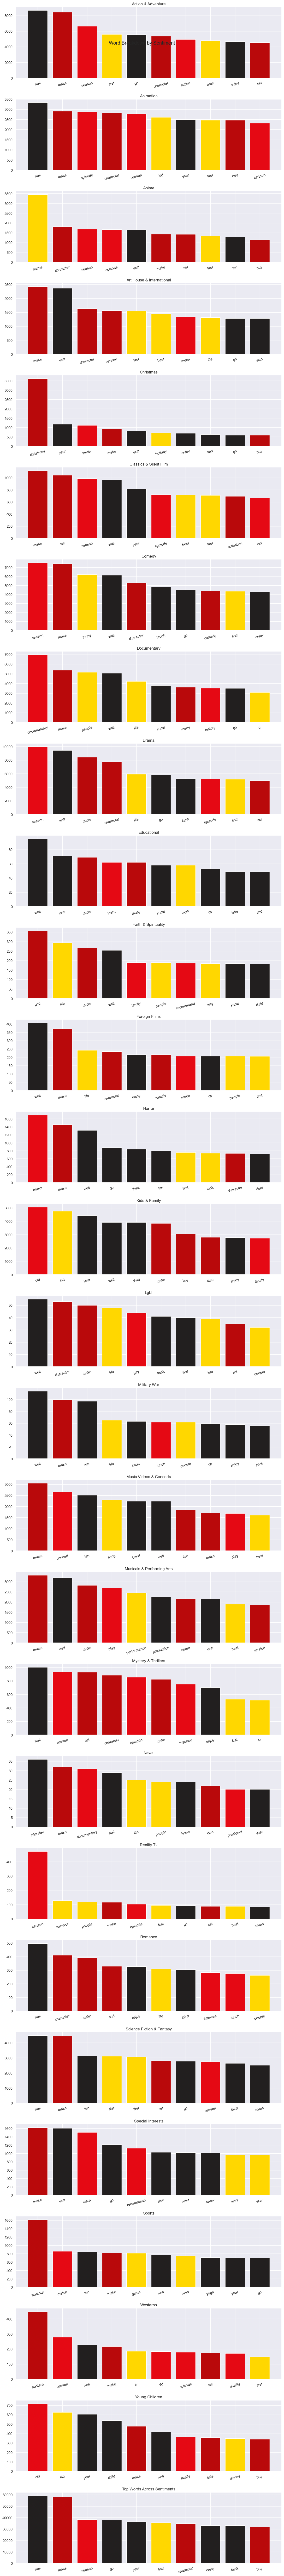

In [53]:
content_based['reviews'] = content_based['reviews'].apply(tokenize_sw)
freq_words = word_plot(content_based, 'genre', 'reviews',
    n_words=10, theme=flix_colors)

In [56]:
last_words = [
    'well', 'make', 'season', 'go', 'year', 'first', 'character', 'enjoy', 'buy', 'think',
    'episode', 'best', 'version', 'excellent', 'two', 
]

sw.extend(last_words)

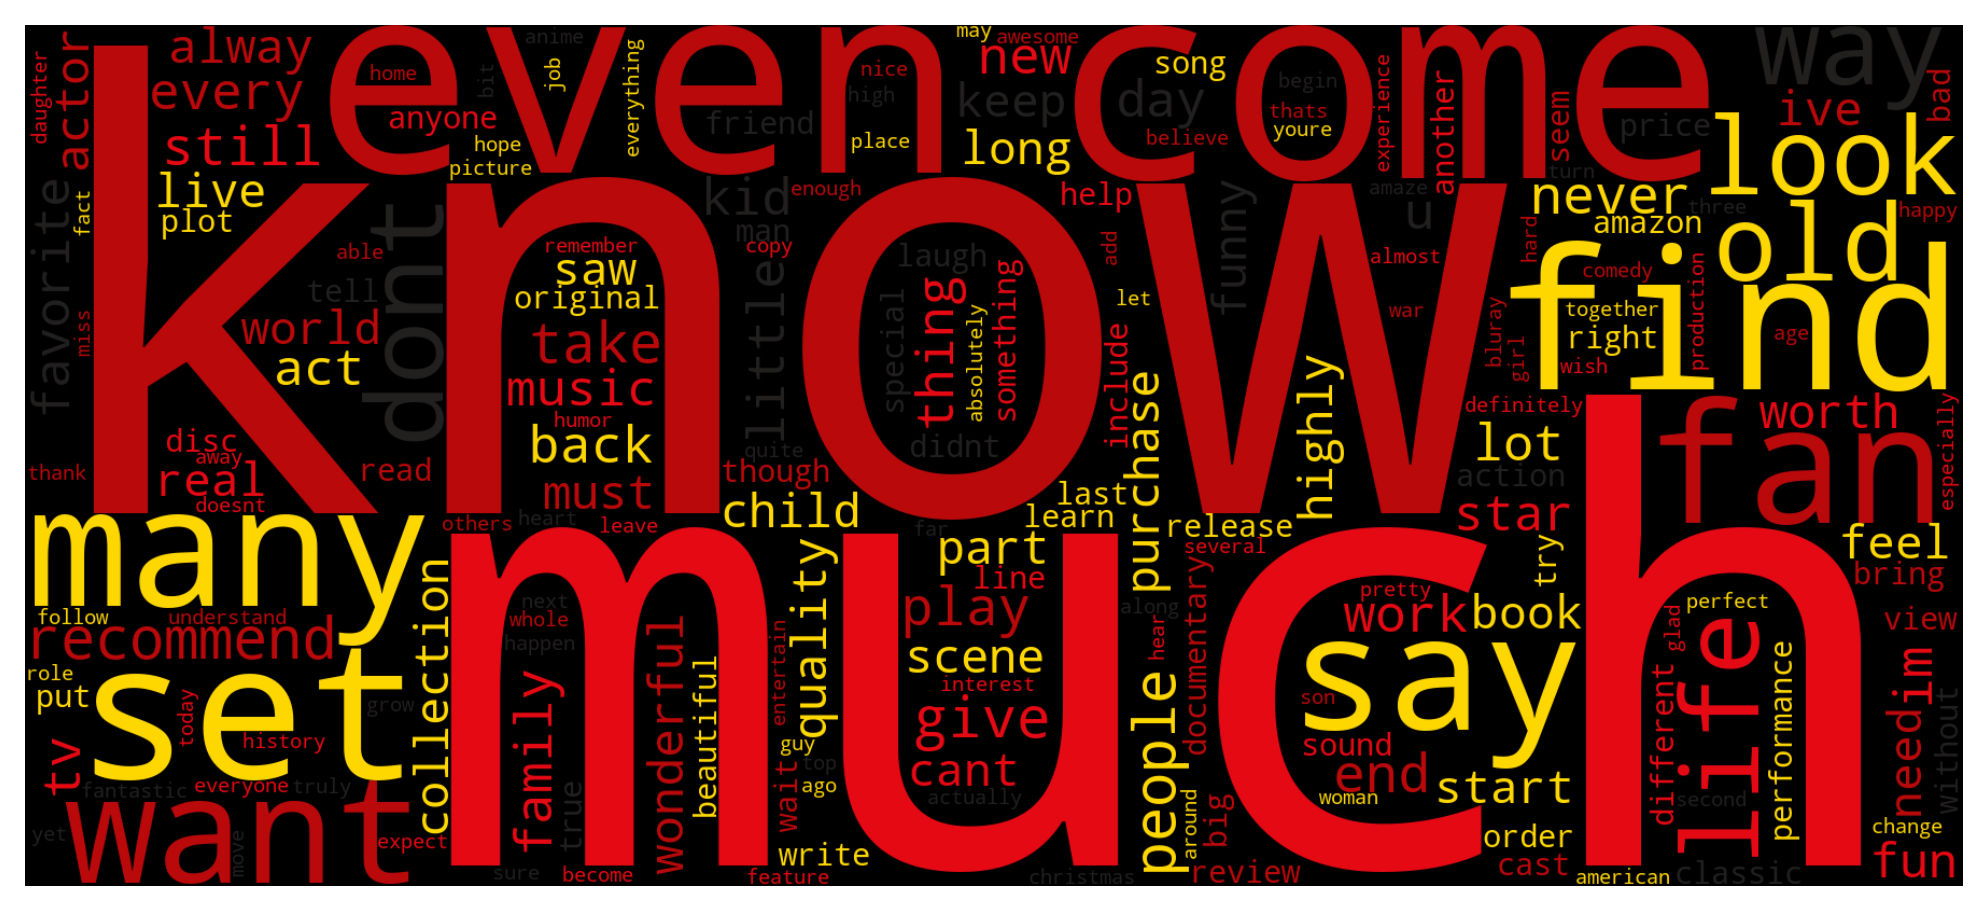

In [57]:
content_based['reviews'] = content_based['reviews'].apply(tokenize_sw)
wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='black'
).generate(' '.join(content_based['reviews']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
content_based.info()

In [73]:
vectorizer = TfidfVectorizer(max_features=460)
tf_genre = vectorizer.fit_transform(content_based['reviews'])
tf_genre = pd.DataFrame(tf_genre.todense(), columns=vectorizer.get_feature_names_out(), index=content_based.index)
tf_genre = pd.concat([content_based.drop(['reviews'], axis=1), tf_genre], axis=1)
tf_genre = pd.get_dummies(tf_genre, columns=['genre'], dtype=int)
tf_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206041 entries, 0005092663 to B01HJ6R77G
Columns: 487 entries, 10 to genre_Young Children
dtypes: float64(460), int32(27)
memory usage: 745.9+ MB


In [85]:
movie_df.drop(columns=['rating','user_id','reviews'], axis=1, inplace=True)
movie_df.drop_duplicates(subset='movie_id', inplace=True)
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37534 entries, 35 to 2346443
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     37534 non-null  object
 1   genre        37534 non-null  object
 2   description  37534 non-null  object
 3   title        37534 non-null  object
 4   starring     37534 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


### Similarity Algorithm Functions:

**cos_recs_genre()**: Calculates similarity scores between movies using cosine_similarity() from sklearn, leveraging TF-IDF features.

**knn_recs_genre()**: Employs NearestNeighbors model from sklearn with 'cosine' metric, conducting k-nearest neighbors search based on cosine similarity.

Both return the top 5 recommendations for a movie. The first calculates the cosine similarity matrix directly, while the second utilizes a k-nearest neighbors model.

### Performance & Evaluation:
The system performs well, suggesting new movies based on genre and word vector similarities. However, it leans towards movies of the same genre, working well for specific genres like 'Faith & Spirituality', but offering dissimilar recommendations for broader genres like 'Science Fiction & Fantasy'.

In [86]:
def cos_recs_genre(movie_id):
    input_movie_info = movie_df.loc[movie_df.movie_id == movie_id, ['title', 'genre', 'starring']]
    
    cosine_matrix = cosine_similarity(tf_genre)
    
    similarity_scores = pd.Series(cosine_matrix[tf_genre.index.get_loc(movie_id)], index=tf_genre.index)
    
    sorted_scores = similarity_scores.sort_values(ascending=False)
    
    top_recommendations = sorted_scores.loc[sorted_scores.index != movie_id].head(5)
    
    recommended_movies = movie_df.loc[movie_df.movie_id.isin(top_recommendations.index), ['title', 'genre', 'starring', 'movie_id']]
    
    print("Input movie information:")
    print(input_movie_info.to_string(index=False))
    print("\nRecommended movies:")
    return recommended_movies

In [87]:
def knn_recs_genre(movie_id):
    input_movie_info = movie_df.loc[movie_df.movie_id == movie_id, ['title', 'genre', 'starring']]

    features = tf_genre

    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    model.fit(features.values)

    distances, indices = model.kneighbors(features.loc[movie_id].to_numpy().reshape(1, -1), return_distance=True)

    top_recommendations = [tf_genre.index[i] for i in indices[0][1:]]
    
    recommended_movies = movie_df.loc[movie_df.movie_id.isin(top_recommendations), ['title', 'genre', 'starring','movie_id']]

    print("Input movie information:")
    print(input_movie_info.to_string(index=False))
    print("\nRecommended movies:")
    return recommended_movies

In [88]:
cosine_recommendations_genre = cos_recs_genre('0307142493')
cosine_recommendations_genre

MemoryError: Unable to allocate 316. GiB for an array with shape (206041, 206041) and data type float64

In [80]:
knn_recommendations_genre = knn_recs_genre('0307142493')
knn_recommendations_genre

ValueError: X has 5844 features, but NearestNeighbors is expecting 487 features as input.